# Final Project - Bayesian model selection

In [1]:
import arviz as az
import numpy as np
import pymc3 as pm

from matplotlib import pyplot as plt
from scipy.special import betaln
from scipy.stats import beta

In [2]:

np.random.seed(11)           # for reproducibility
a=0.25                       # biased coin
flips=np.random.rand(2**12)  # simulates 4096 coin flips
heads=flips<a    # boolean array, heads[i]=True if flip i is heads
np.sum(heads)

983

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.385
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.394
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000


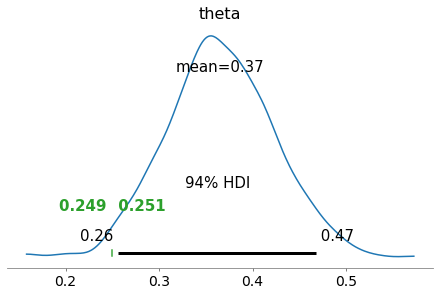

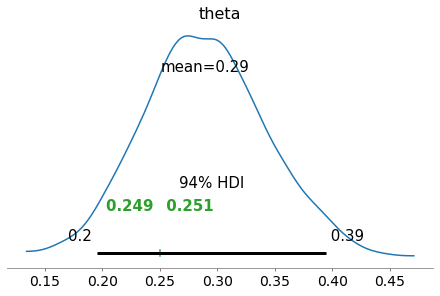

In [3]:
with pm.Model() as model1: #model of a fair coin
    theta = pm.Normal("theta",mu=.5,sigma=.1) #prior for the parameter theta
    yl = pm.Bernoulli("yl", theta, observed=heads[:50]) #likelihood given the measured data
    trace1 = pm.sample_smc(1000, random_seed=42, parallel=False) #sample from posterior
with pm.Model() as model2: #model of biased coin  
    theta = pm.Normal("theta",mu=.25,sigma=.1) #prior for the parameter theta
    yl = pm.Bernoulli("yl", theta, observed=heads[:50]) #likelihood given the measured data
    trace2 = pm.sample_smc(1000, random_seed=42, parallel=False) #sample from posterior
with model1:
    az.plot_posterior(trace1,rope=[0.249,0.251])
with model2:
    az.plot_posterior(trace2,rope=[0.249,0.251])


In [4]:
theta_array=trace1["theta"]
norm_const=len(trace1["theta"])
BF_smc = np.exp(trace2.report.log_marginal_likelihood - trace1.report.log_marginal_likelihood)#bayes factor
BF_smc

array([3.47885066, 3.52248701])

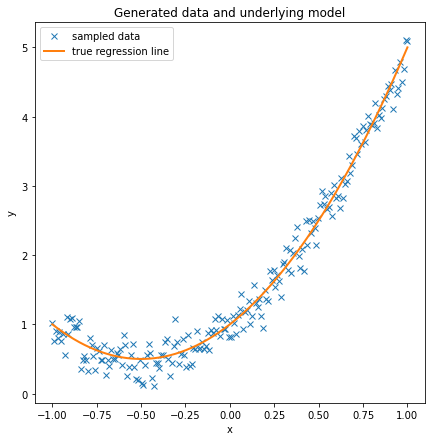

In [5]:
size = 200
true_intercept = 1
true_slope = 2
true_sq=2

x = np.linspace(-1, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x+2*x**2
# add noise
y = true_regression_line + np.random.normal(scale=0.2, size=size)

data = dict(x=x, y=y)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);


In [6]:
sampleSize = 1000

with pm.Model() as lin_model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    m = pm.Normal("m", 0, sigma=20)
    
    mu = pm.Deterministic('mu', intercept + m * x)
    # Define likelihood
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    # Inference!
    lin_trace =  pm.sample_smc(sampleSize, random_seed=42, parallel=False) 

with pm.Model() as const_model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    #x_coeff = pm.Normal("x", 0, sigma=20)

    # Define likelihood
    mu = pm.Deterministic('mu', intercept+x*0)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    # Inference!
    const_trace =  pm.sample_smc(sampleSize, random_seed=42, parallel=False) 
    
with pm.Model() as sq_model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    #x_coeff = pm.Normal("x", 0, sigma=20)
    a = pm.Normal("a", 0, sigma=20)
    b = pm.Normal("b", 0, sigma=20)
    
    # Define likelihood
    mu = pm.Deterministic('mu', intercept+x*b+a*x**2)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    # Inference!
    sq_trace =  pm.sample_smc(sampleSize, random_seed=42, parallel=False) 
with pm.Model() as cub_model:
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    a = pm.Normal("a", 0, sigma=20)
    b = pm.Normal("b", 0, sigma=20)
    c = pm.Normal("c", 0, sigma=20)
    mu = pm.Deterministic('mu', intercept+c*x+b*x**2+a*x**3)
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
    # Inference!
    cub_trace =  pm.sample_smc(sampleSize, random_seed=42, parallel=False) 

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.008
Stage:   2 Beta: 0.014
Stage:   3 Beta: 0.022
Stage:   4 Beta: 0.035
Stage:   5 Beta: 0.052
Stage:   6 Beta: 0.082
Stage:   7 Beta: 0.136
Stage:   8 Beta: 0.259
Stage:   9 Beta: 0.562
Stage:  10 Beta: 1.000
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.008
Stage:   2 Beta: 0.013
Stage:   3 Beta: 0.019
Stage:   4 Beta: 0.030
Stage:   5 Beta: 0.050
Stage:   6 Beta: 0.098
Stage:   7 Beta: 0.223
Stage:   8 Beta: 0.549
Stage:   9 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.008
Stage:   2 Beta: 0.016
Stage:   3 Beta: 0.034
Stage:   4 Beta: 0.088
Stage:   5 Beta: 0.280
Stage:   6 Beta: 0.949
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.008
Stage:   2 Beta: 0.016
Stage:   3 Beta: 0.035
Stage:   4 Beta: 0.095
Stage:   5 Beta: 0.299
Stage:   6 Beta: 1.000
Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stag

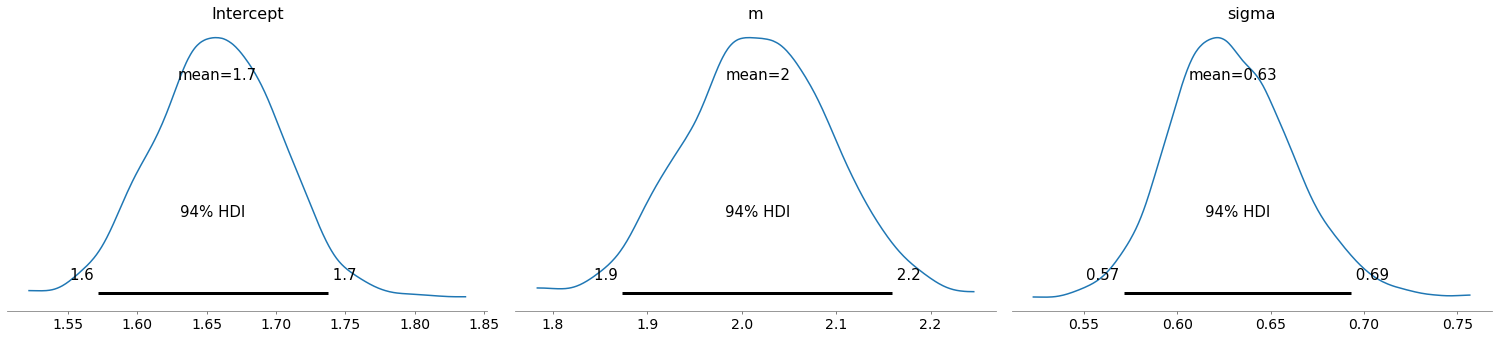

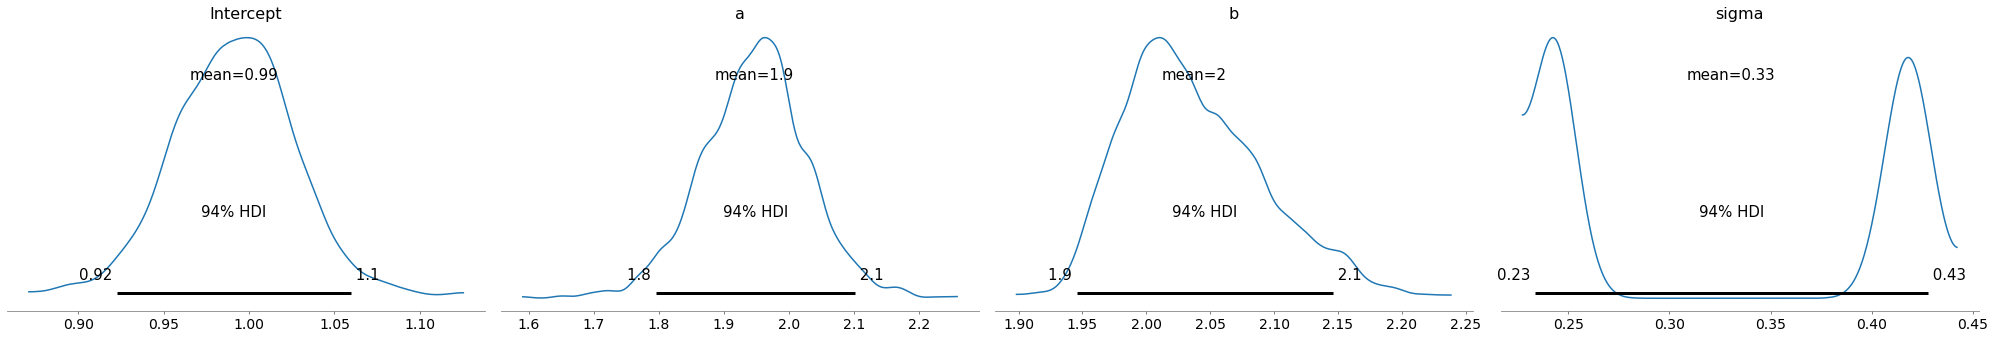

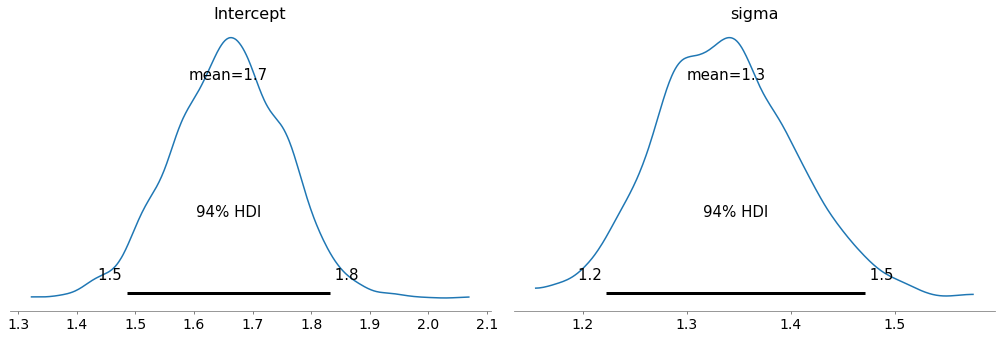

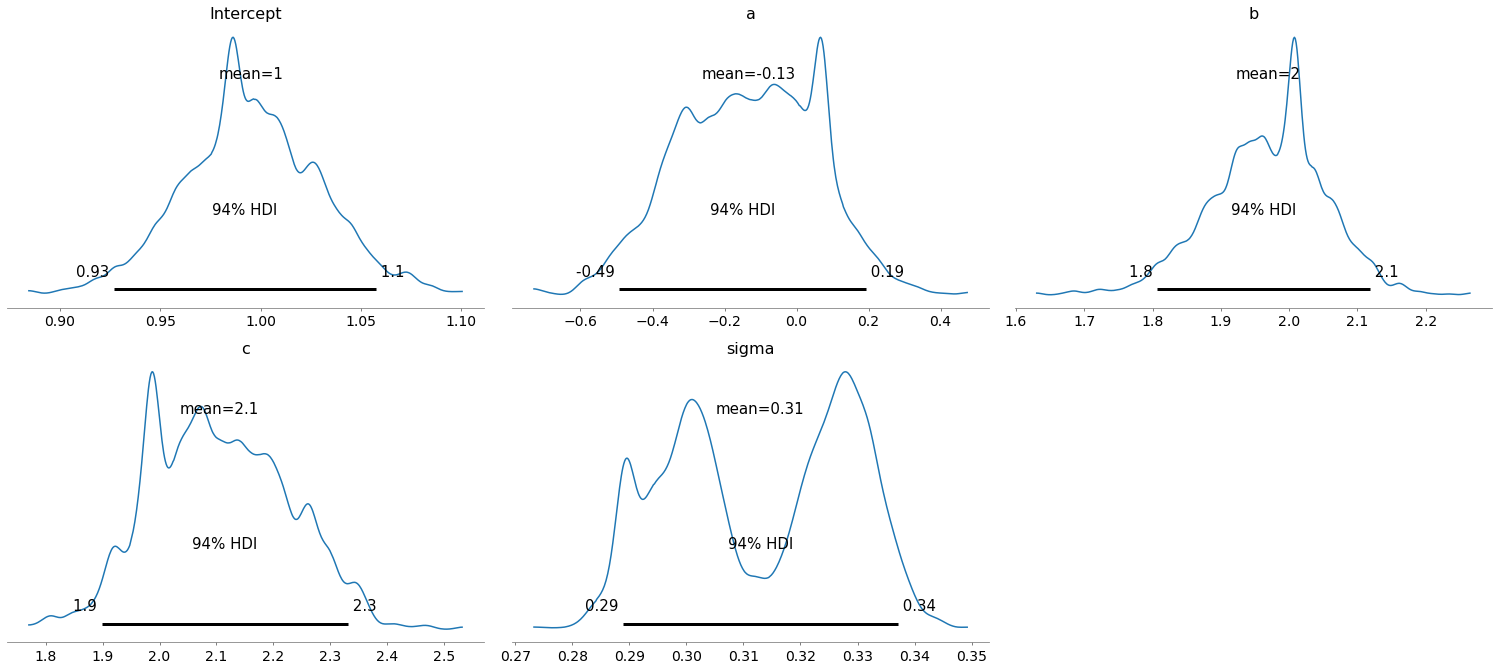

In [7]:
with lin_model:
    az.plot_posterior(lin_trace, var_names=['Intercept', 'm', 'sigma'])

with sq_model:
    az.plot_posterior(sq_trace, var_names=['Intercept', 'a', 'b','sigma'])    

with const_model:
    az.plot_posterior(const_trace, var_names=['Intercept', 'sigma'])
with cub_model:
    az.plot_posterior(cub_trace, var_names=['Intercept', 'a','b','c','sigma'])
    

/usr/local/lib/python3.9/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.9/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/

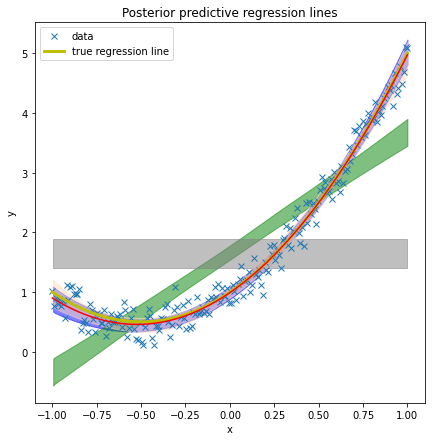

In [8]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, "x", label="data")
#pm.plot_posterior_predictive_glm(lin_trace, samples=100, label="posterior predictive regression lines")
plt.plot(x, true_regression_line, label="true regression line", lw=3.0, c="y")

plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");
sig2 = az.plot_hpd(x, sq_trace['mu'], credible_interval=.99, color='b')
sig1 = az.plot_hpd(x, lin_trace['mu'], credible_interval=.99, color='g')
plt.plot(x, np.mean(sq_trace['Intercept'])+np.mean(sq_trace['a'])*x**2+np.mean(sq_trace['b'])*x, color='red')
sig3 = az.plot_hpd(x, const_trace['mu'], credible_interval=.99, color='gray')
sig4= az.plot_hpd(x, cub_trace['mu'], credible_interval=.99, color='peachpuff')

In [9]:
def Bayes_Factor(trace1, trace2):
    return  np.exp(trace1.report.log_marginal_likelihood - trace2.report.log_marginal_likelihood)#bayes factor

Bayes_Factor(sq_trace, const_trace)


array([1.27146501e+109, 3.78337670e+138])

## Bayes Complexity

In [19]:
#for now lets assume we look at a polynomial of degree n

def poly_model(x,params): #params is array from highest order to lowest order of coefficents
    #print('params in polymodel \n')
    #print(params)
    order=len(params)
    #print(order)
    y=0
    for i in range(order):
        #print(params[-i-1])
        y=x**i*params[-i-1]
        #print(params[-i-1])
    return y

def logli(sigma,datapoints_x,datapoints_y,params):
    #print('params in logli \n')
    #print(params)
    N=len(datapoints_x)
    loglikelihood=-N/2*np.log(2*np.pi)-N*np.log(sigma)
    tmp=0
    for i in range(len(datapoints_x)):
        tmp+=(datapoints_y[i]-poly_model(datapoints_x[i],params))**2
    loglikelihood-=1/2*tmp/(sigma**2)
    #print(loglikelihood)
    return loglikelihood

def bayes_complexity(datapoints_x,datapoints_y,params,trace):#params is a list of strings with parameter NAMES
    param_means=np.array([np.mean(trace[i])for i in params])
    #print(param_means)
    param_samples=np.array([trace[i] for i in params])
    #print(param_samples)
    sigma_mean=np.mean(trace['sigma'])
    sigma_samples=np.array(trace['sigma'])
   
    #print(sigma_samples)
    #to do: average of loglikelihood with respect to param_samples
    loglikelihood=logli(sigma_samples,datapoints_x,datapoints_y,param_samples)
    
    mean_loglikelihood=logli(sigma_mean,datapoints_x,datapoints_y,param_means)
    #print(mean_loglikelihood)
    return (-2*np.mean(loglikelihood)+2*mean_loglikelihood) #divide by sample size to ensure normalization of posterior

def marginal_likelihood():
    return 0

const_params=['Intercept']
cub_params=['a','b','c','Intercept']
sq_params=['a','b','Intercept']
lin_params=['m','Intercept']
#print(logli(0.21,y,[2,2,1]))
#param_means=[sq_trace[i]for i in params]
bayes_complexity(x,y,cub_params,cub_trace)

65.5583594373984

## Experimental.... not working

In [11]:
test=1
test2=[1,2,3]
test-np.log(test2)


array([ 1.        ,  0.30685282, -0.09861229])

In [12]:
#sampleSize = 5000
#size = 500
#x = np.linspace(-np.pi, np.pi, size)
## y = a + b*x
#true_regression_line = 2*np.sin(x+0)+1
## add noise
#y = true_regression_line + np.random.normal(scale=0.2, size=size)
#plt.plot(x,y,'bx',x,true_regression_line,'r--')
#with pm.Model() as sin_model:  # model specifications in PyMC3 are wrapped in a with-statement
#    # Define priors
#    sigma = pm.HalfCauchy("sigma", beta=5, testval=1.0)
#    A = pm.Normal("A",0, sigma=10)
#    omega = pm.Normal("omega", 0, sigma=5)
#    phi = pm.Normal("phi", 0, sigma=5)
#    intercept = pm.Normal("intercept", 0, sigma=5)
#
#    # Define likelihood
#    sin = pm.Deterministic('sin', A*np.sin(omega*x+phi)+intercept)
#    likelihood = pm.Normal("y", mu=sin, sigma=sigma, observed=y)
#
#    # Inference!
#    sin_trace =  pm.sample_smc(sampleSize) 
#    

In [13]:
#az.plot_trace(sin_trace, var_names=['A', 'omega', 'phi', 'sigma','intercept'])


In [14]:
#x = np.linspace(-5, 5, size)
## y = a + b*x
#true_regression_line = 3*np.exp(-(x-0)**2/(2*1**2))
## add noise
#y = true_regression_line + np.random.normal(scale=0.3, size=size)
#plt.plot(x,y, "x")
#plt.plot(x, true_regression_line)
#sig1 = az.plot_hpd(x, gauss_trace['gauss'], credible_interval=.99, color='g')
#

In [15]:
#x=np.linspace(-1,1,100)
#y=poly_model(x,[1,2,3])
#sq_trace
#plt.plot(x,y,'b--',x,x**2+2*x+3,'r-.')
#plt.show()

In [16]:
test = [1,1,1,2,2,2]
np.sum(test)/len(test)
np.mean(test)

1.5